In [1]:
import os
import logging
import statistics

import pandas as pd
import matplotlib.pyplot as plt

import gym

gym.undo_logger_setup()  # NOQA
from chainer import functions as F
from chainer import links as L
from chainer import optimizers
import numpy as np

import chainerrl
from chainerrl.action_value import DiscreteActionValue
from chainerrl import agents
from chainerrl import experiments
from chainerrl import explorers
from chainerrl import links
from chainerrl import misc
from chainerrl.q_functions import DuelingDQN
from chainerrl import replay_buffer

import atari_wrappers

/Users/sykwer/work/i18-sykwer/visualize_atari/venv/lib/python3.7/site-packages/gym/__init__.py:15: UserWarning: gym.undo_logger_setup is deprecated. gym no longer modifies the global logging configuration
  warnings.warn("gym.undo_logger_setup is deprecated. gym no longer modifies the global logging configuration")
/Users/sykwer/work/i18-sykwer/visualize_atari/venv/lib/python3.7/site-packages/chainer/_environment_check.py:38: UserWarning: Accelerate has been detected as a NumPy backend library.
vecLib, which is a part of Accelerate, is known not to work correctly with Chainer.
We recommend using other BLAS libraries such as OpenBLAS.
For details of the issue, please see
https://docs.chainer.org/en/stable/tips.html#mnist-example-does-not-converge-in-cpu-mode-on-mac-os-x.

Also note that Chainer does not officially support Mac OS X.
Please use it at your own risk.

  ''')  # NOQA


In [2]:
random_seed = 1
outdir = "results"
env_name = "BreakoutNoFrameskip-v4"
load_dir = "../visualize_atari/results/211288/20180804T155228.325999/10000000_finish"

In [3]:
def make_env():
    env = atari_wrappers.wrap_deepmind(
        atari_wrappers.make_atari(env_name),
        episode_life=False, clip_rewards=False
    )
    env.seed(random_seed)
    # misc.env_modifiers.make_rendered(env)
    return env
env = make_env()

In [4]:
print("observation space shape: {}".format(env.observation_space.shape))
print("action size: {}".format(env.action_space.n))

observation space shape: (4, 84, 84)
action size: 4


In [5]:
q_func = links.Sequence(
    links.NatureDQNHead(activation=F.relu),
    L.Linear(512, env.action_space.n),
    DiscreteActionValue,
)
opt = optimizers.RMSpropGraves(lr=2.5e-4, alpha=0.95, momentum=0.0, eps=1e-2)
opt.setup(q_func)
rep_buf = replay_buffer.ReplayBuffer(10 ** 6)
explorer = explorers.LinearDecayEpsilonGreedy(
    1,0, 0.1, 10 ** 6, lambda: np.random.randint(env.action_space.n),
)

In [6]:
agent = agents.DQN(q_func, opt, rep_buf, gpu=-1, gamma=0.99, explorer=explorer, replay_start_size=5 * 10**4,
           target_update_interval=10**4, clip_delta=True, update_interval=4, batch_accumulator="sum",
            phi=lambda x: np.asarray(x, np.float32) / 255)
# agent.load(load_dir)

In [7]:
qvalue_list1 = []
qvalue_list2 = []
qvalue_list3 = []
qvalue_list4 = []
image_list = []
action_list = []

obs = env.reset()
done = False
test_r = 0
t = 0

while not (done or t == 1800): # max_episode_len
    image_list.append(env.render(mode="rgb_array"))
    
    qvalues = agent.model(agent.batch_states([np.asarray(obs)], agent.xp, agent.phi)).q_values.data[0]
    qvalue_list1.append(qvalues[0])
    qvalue_list2.append(qvalues[1])
    qvalue_list3.append(qvalues[2])
    qvalue_list4.append(qvalues[3])
    
    a = agent.act(obs)
    action_list.append(a)
    
    obs, r, done, info = env.step(a)
    test_r += r
    t += 1

agent.stop_episode()
print("episode reward: {}".format(test_r))

WARN: <class 'atari_wrappers.FrameStack'> doesn't implement 'reset' method, but it implements deprecated '_reset' method.
episode reward: 0.0


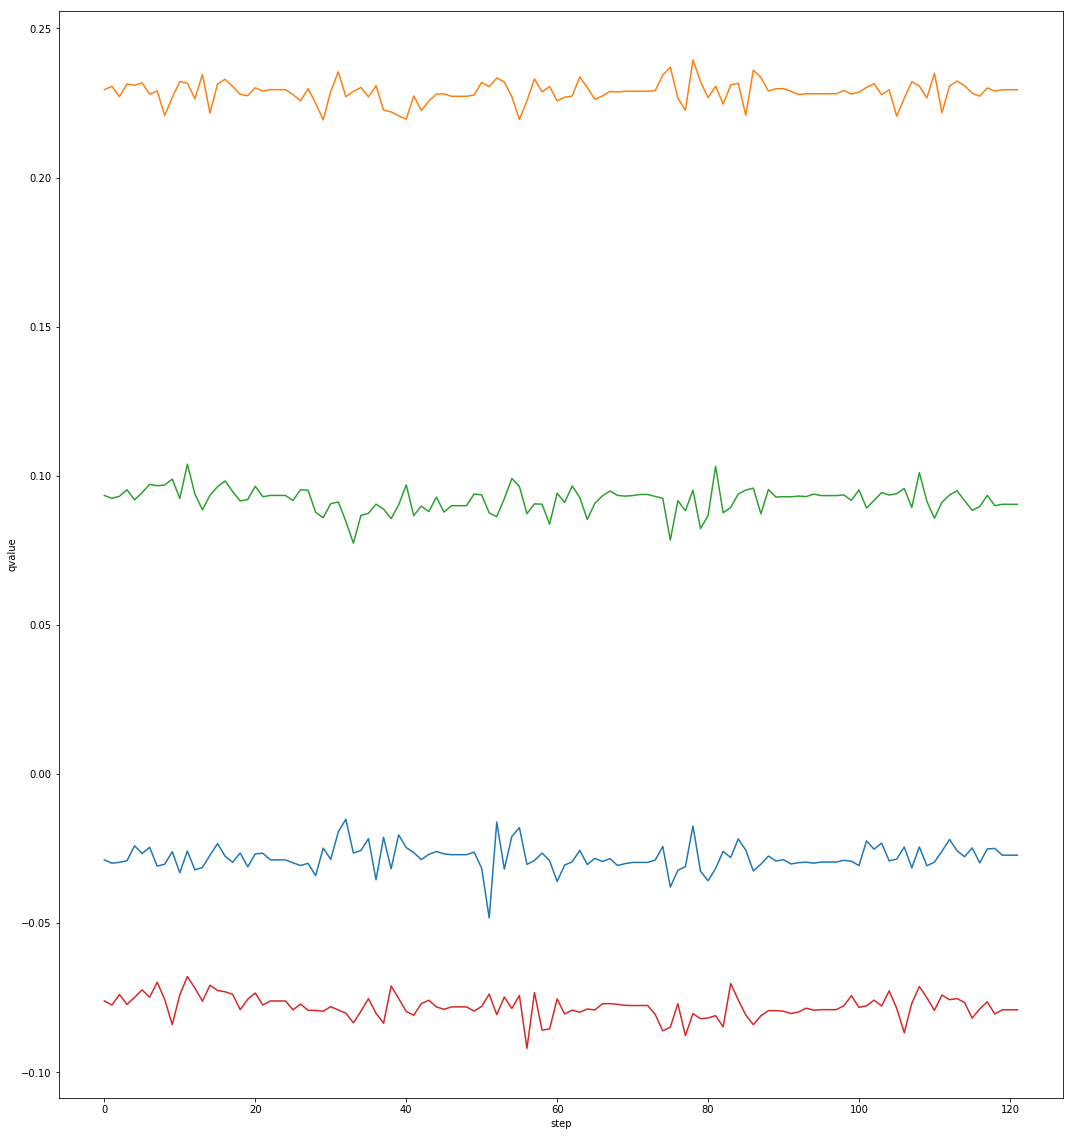

In [8]:
fig = plt.figure(figsize=[18, 20])
axis = fig.add_subplot(111)

step_idxs = np.arange(0, len(qvalue_list1), 1)

axis.plot(step_idxs, qvalue_list1)
axis.plot(step_idxs, qvalue_list2)
axis.plot(step_idxs, qvalue_list3)
axis.plot(step_idxs, qvalue_list4)

axis.set_xlabel("step")
axis.set_ylabel("qvalue")

plt.show()

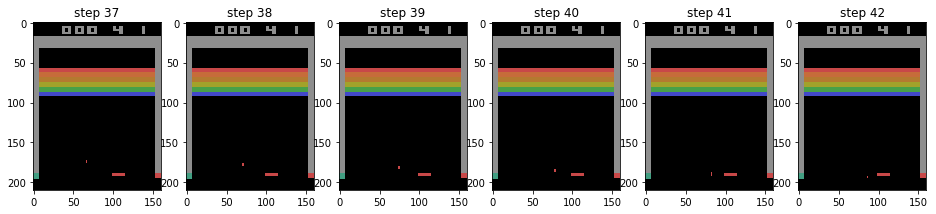

In [19]:
fig = plt.figure(figsize=[16, 12])
j = 1
for i in range(37, 43):
    ax = fig.add_subplot("16{}".format(j))
    j += 1
    
    ax.imshow(image_list[i])
    ax.set_title("step {}".format(i))
plt.show()